<a href="https://www.kaggle.com/code/brianvilnrotter/mars-rover-machine-learning-python-practice?scriptVersionId=203219248" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mars-rover-environmental-monitoring-station/REMS_Mars_Dataset.csv


# Mission Statement

## Purpose
the goal of this notebook is to analyze the Curiosity rover data in order to come to the conclusion whether the data by itself showns any correlation between its attributes that can be used to train a predictive model. The specific comparisons involve all date and numerical values. Despite there being Mars calendar values I'll be focusing on the earth dates as pandas can parse those dates easier. I do recognize this is a blindsight on my part as the Earth rotations are different that Martian rotations which could impact the correlation graphs.

## Sections

1. Imported modules
2. Graphical comparisons

## 1. Imported modules

In [2]:
# Import other modules
import matplotlib.pyplot as plt

In [3]:
# Import the scikit-learn modules
from sklearn.model_selection import train_test_split
from sklearn import linear_model

## 2. Check the comparisons

In [4]:
# Add data to dataframe
df = pd.read_csv("/kaggle/input/mars-rover-environmental-monitoring-station/REMS_Mars_Dataset.csv")
df.head()

,earth_date_time,mars_date_time,sol_number,max_ground_temp(°C),min_ground_temp(°C),max_air_temp(°C),min_air_temp(°C),mean_pressure(Pa),wind_speed(m/h),humidity(%),sunrise,sunset,UV_Radiation,weather
0,"Earth, 2022-01-26 UTC","Mars, Month 6 - LS 163°",Sol 3368,-3,-71,10,-84,707,Value not available,Value not available,05:25,17:20,moderate,Sunny
1,"Earth, 2022-01-25 UTC","Mars, Month 6 - LS 163°",Sol 3367,-3,-72,10,-87,707,Value not available,Value not available,05:25,17:20,moderate,Sunny
2,"Earth, 2022-01-24 UTC","Mars, Month 6 - LS 162°",Sol 3366,-4,-70,8,-81,708,Value not available,Value not available,05:25,17:21,moderate,Sunny
3,"Earth, 2022-01-23 UTC","Mars, Month 6 - LS 162°",Sol 3365,-6,-70,9,-91,707,Value not available,Value not available,05:26,17:21,moderate,Sunny
4,"Earth, 2022-01-22 UTC","Mars, Month 6 - LS 161°",Sol 3364,-7,-71,8,-92,708,Value not available,Value not available,05:26,17:21,moderate,Sunny


### 2.1 Cleaning the data
There are a number of columns that must be cleaned before they can be analyzed, predominately the `earth_date_time` column which needs to have the date string pulled (it does not contain time), and then converted to datetime dtype. This value will be added to a new datatime so as to not delete potentially relevant data called `shaved_earth_date_time`. Another good thing to do here is convert all string values that show no data, `Value not available` as `np.nan` to help with future cleaning tasks.

In [5]:
df["shaved_earth_date_time"] = pd.to_datetime(df["earth_date_time"].str.replace('Earth, ','').str.replace(' UTC',''),format='%Y-%m-%d')

In [6]:
df = df.replace("Value not available",np.nan)

/tmp/ipykernel_17/1868828781.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace("Value not available",np.nan)


Furthermore, there are some values (like humidity and weather) that look like they may have some potentially beneficial data involving categorical data that could be converted into numerical data (low, medium, high). These columns should be checked for unigue values to see if we can use this data.

In [7]:
df["humidity(%)"].unique(),df["UV_Radiation"].unique(),df["wind_speed(m/h)"].unique(),df["weather"].unique()

(array([nan]),
 array(['moderate', 'low', 'high', 'very_high', nan], dtype=object),
 array([nan]),
 array(['Sunny', nan], dtype=object))

It looks like the majority of column data checked do not have data that can be used to compare to other attributes, spare `UV_Radiation` which will have to be converted into a schema `{low:0.0,medium:1.0,high:2.0,nan:np.nan}`

Furthermore, the `sunset` and `sunrise` data can be used within this attribute comparison exercise once converted into `time` objects (most likely `datetime` objects). This would bring the total number of attributes to (9) nine.

**Attributes to compare**
1. `earth_date_time` => `shaved_earth_date_time`
2. `max_ground_temp(°C)`
3. `min_ground_temp(°C)`
4. `max_air_temp(°C)`
5. `min_air_temp(°C)`
6. `mean_pressure(Pa)`
7. `sunrise`
8. `sunset`
9. `UV_Radiation`

The first thing we should do is create a new dataframe that contains the columns of data we're interested in, and see what the data types are of the columns and convert dtypes as needed.

In [8]:
relevant_df = df[[
    'shaved_earth_date_time',
    'max_ground_temp(°C)',
    'min_ground_temp(°C)',
    'max_air_temp(°C)',
    'min_air_temp(°C)',
    'mean_pressure(Pa)',
    'sunrise',
    'sunset',
    'UV_Radiation'
]]

In [9]:
relevant_df = relevant_df.astype({
    'max_ground_temp(°C)':float,
    'min_ground_temp(°C)':float,
    'max_air_temp(°C)':float,
    'min_air_temp(°C)':float,
    'mean_pressure(Pa)':float
})

In [10]:
relevant_df['sunrise'] = pd.to_datetime(relevant_df['sunrise'],format="%H:%M")
relevant_df['sunset'] = pd.to_datetime(relevant_df['sunset'],format="%H:%M")

In [11]:
# create a priority map of the values for UV_Radiation
mapping = {
    'low':0.0,
    'moderate':1.0,
    'high':2.0,
    'very_high':3.0,
}
relevant_df['UV_Radiation_map'] = (relevant_df['UV_Radiation'].map(mapping)).astype('float')

In [12]:
relevant_df = relevant_df.drop('UV_Radiation',axis=1)

In [13]:
relevant_df.dtypes

shaved_earth_date_time    datetime64[ns]
max_ground_temp(°C)              float64
min_ground_temp(°C)              float64
max_air_temp(°C)                 float64
min_air_temp(°C)                 float64
mean_pressure(Pa)                float64
sunrise                   datetime64[ns]
sunset                    datetime64[ns]
UV_Radiation_map                 float64
dtype: object

### 2.2 Compare attributes

Before we dig deeper into specific comparisions, we should get an overarching view of the data as a whole.

In [14]:
relevant_df.describe()

,shaved_earth_date_time,max_ground_temp(°C),min_ground_temp(°C),max_air_temp(°C),min_air_temp(°C),mean_pressure(Pa),sunrise,sunset,UV_Radiation_map
count,3197,3169.000000,3169.000000,3168.000000,3168.000000,3170.000000,3197,3197,3170.000000
mean,2017-05-06 12:15:05.348764416,-13.209214,-75.016409,2.010732,-80.317551,828.792429,1900-01-01 05:59:34.644979456,1900-01-01 17:57:44.798248448,1.579180
min,2012-08-07 00:00:00,-67.000000,-100.000000,-61.000000,-136.000000,702.000000,1900-01-01 05:18:00,1900-01-01 17:20:00,0.000000
25%,2015-01-04 00:00:00,-23.000000,-79.000000,-6.000000,-86.000000,785.000000,1900-01-01 05:33:00,1900-01-01 17:28:00,1.000000
50%,2017-04-28 00:00:00,-12.000000,-75.000000,3.000000,-80.000000,843.000000,1900-01-01 05:56:00,1900-01-01 17:47:00,2.000000
75%,2019-09-23 00:00:00,-4.000000,-71.000000,10.000000,-75.000000,873.000000,1900-01-01 06:27:00,1900-01-01 18:29:00,2.000000
max,2022-01-26 00:00:00,11.000000,-52.000000,24.000000,-8.000000,925.000000,1900-01-01 06:47:00,1900-01-01 18:55:00,3.000000
std,NaN,10.493719,5.529282,9.401705,8.845239,57.119649,NaN,NaN,0.689969


In [15]:
relevant_df.isnull().sum()

shaved_earth_date_time     0
max_ground_temp(°C)       28
min_ground_temp(°C)       28
max_air_temp(°C)          29
min_air_temp(°C)          29
mean_pressure(Pa)         27
sunrise                    0
sunset                     0
UV_Radiation_map          27
dtype: int64

In [16]:
relevant_df = relevant_df.dropna()

Below will be the function definition that will take in an axes subplot and graph a trendline and provide an R² value.

This function use the `np.polyfit()` function to fit the linear regression model, then manually calculate out the R² value:

$$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$

**Where:**
- $SS_{res}$ is the residual sum of squares: $\sum{(y_{actual} - y_{predicted})}^2$
- $SS_{tot}$ is the total sum of squares: $\sum{(y_{actual} - \bar{y})}^2$, where $\bar{y}$ is the mean of $y$

**Considerations:**
- polynomial degrees greater than 1 need rework 


In [17]:
# define function to create R² trendlines for axes plots
def plot_trendline(ax,x,y,n=1):
    
    coeffs = np.polyfit(x,y,n)
    poly_eq = np.poly1d(coeffs)
    y_pred = poly_eq(x)
    ax.plot(x,y_pred,color='red',linewidth=2)
    
    # calculate the R² value and set the title to it
    y_mean = np.mean(y)
    ss_tot = np.sum((y - y_mean) ** 2)
    ss_res = np.sum((y - y_pred) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    ax.set_title(f'R² = {r_squared:.2f}')

Then, we will graph all the possible comparisons as small graphs and see which data looks like we can dig more into.

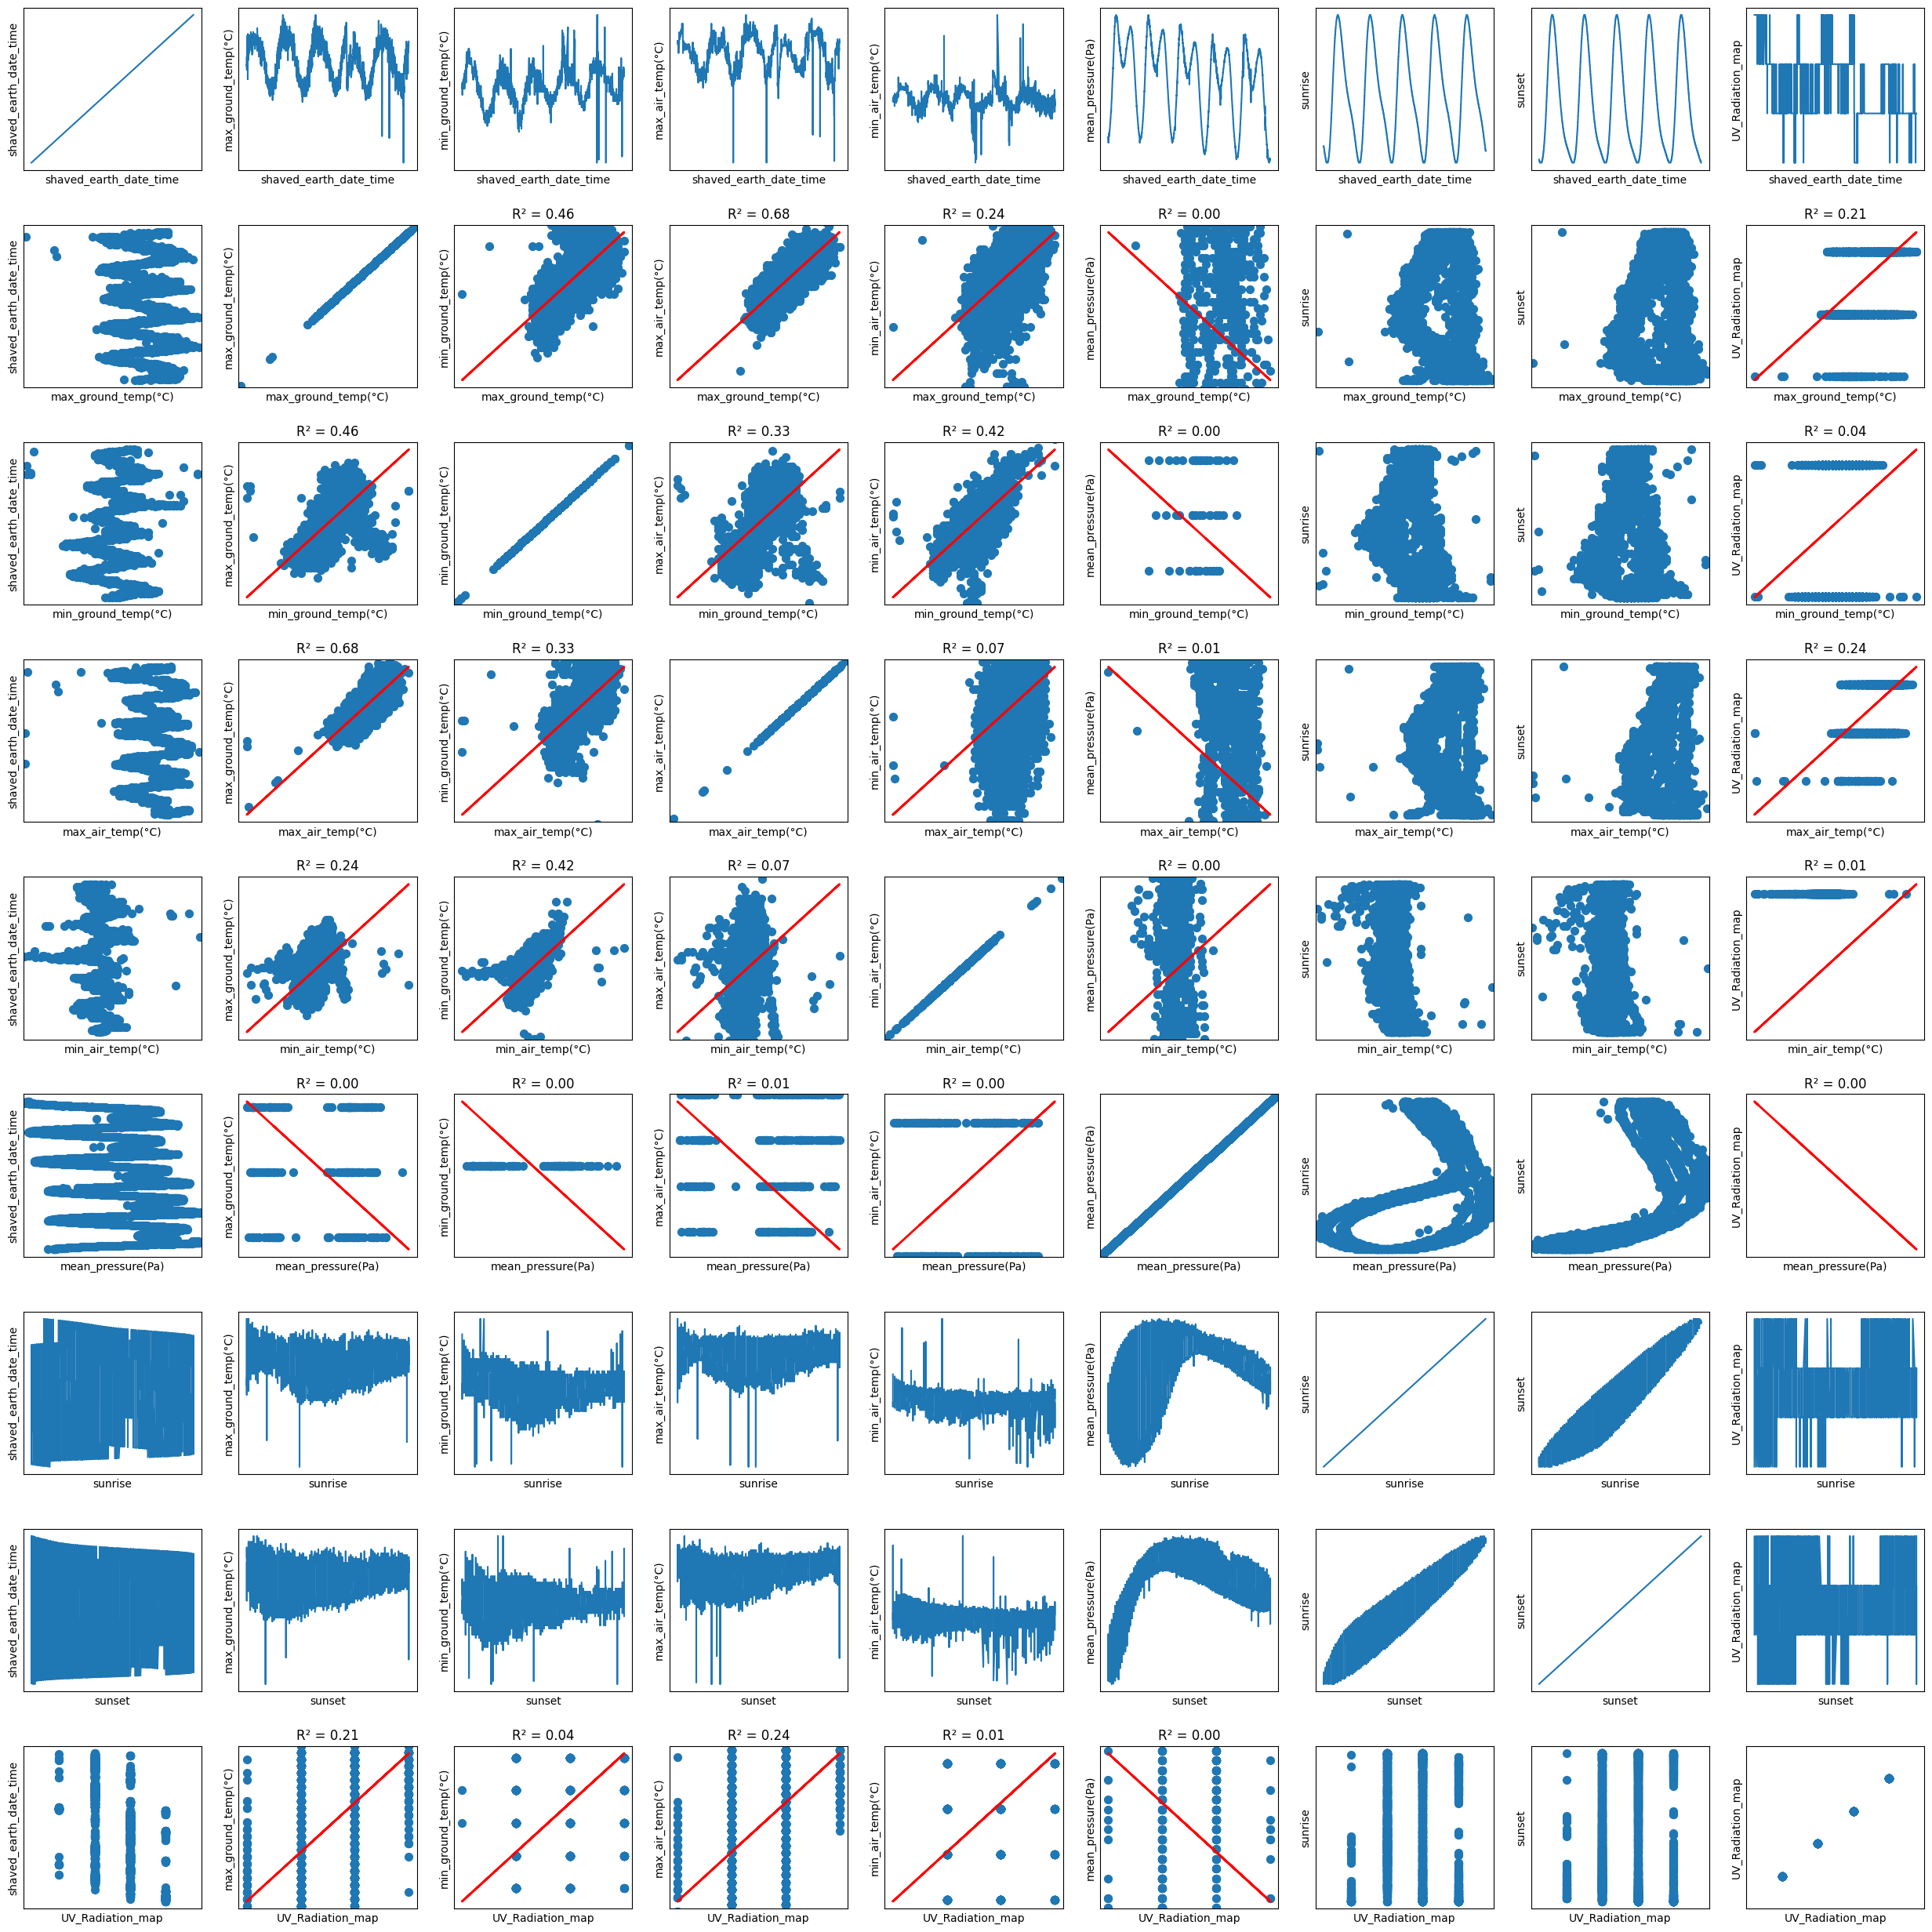

In [18]:
# create the subplots
fig,axes = plt.subplots(nrows=len(relevant_df.columns),ncols=len(relevant_df.columns),figsize=(25,25))

# iterate through the subplots and customziations automatically
for i,column_x in enumerate(relevant_df.columns):
    for j,column_y in enumerate(relevant_df.columns):
        
        # high level graph generation
        if relevant_df[column_x].dtype == 'datetime64[ns]':
            relevant_df = relevant_df.sort_values(by=column_x)
            axes[i][j].plot(relevant_df[column_x],relevant_df[column_y])
        else:
            axes[i][j].scatter(relevant_df[column_x],relevant_df[column_y],s=50)
            
            # set the limits as scatter is not scalling the axis correctly
            axes[i][j].set_xlim([relevant_df[column_x].min()-1,relevant_df[column_x].max()+1])
            if relevant_df[column_y].dtype != 'datetime64[ns]': # avoid scaling the y axis for datetime values
                axes[i][j].set_ylim([relevant_df[column_y].min()-1,relevant_df[column_y].max()+1])
            
            # generate a trendline that spits out the R² value
            if i != j and not relevant_df[column_x].dtype == 'datetime64[ns]' and not relevant_df[column_y].dtype == 'datetime64[ns]':
                plot_trendline(axes[i][j],relevant_df[column_x],relevant_df[column_y])
        
        # customizations in subplot graphs
        axes[i][j].set_xlabel(column_x)
        axes[i][j].set_ylabel(column_y)
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
        axes[i][j].relim()
        axes[i][j].autoscale()

plt.tight_layout(pad=2.0)

### 2.3 Dig deeper

#TODO Continue work on this later